In [2]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Damped Harmonic Oscillator Dynamics

The motion of a damped harmonic oscillator is described by the differential equation:
$$
m\frac{d^2x}{dt^2} + \mu \frac{dx}{dt} + kx = 0
$$

This encompasses three fundamental physical principles:
- **Hooke's Law** for elastic forces: $F = -kx$, indicating the restoring force proportional to the displacement.
- **Newton's Second Law** for motion: $F = m\frac{d^2x}{dt^2}$, relating force to mass and acceleration.
- **Damping Force**: $F_d = - \mu \frac{dx}{dt}$, representing the resistive force proportional to velocity.

Rearranging and normalizing the differential equation yields:
$$
\frac{d^2x}{dt^2} + \frac{\mu}{m}\frac{dx}{dt} + \frac{k}{m}x = 0
$$

By defining $2d = \frac{\mu}{m}$ and $w_0^2 = \frac{k}{m}$, we arrive at a simplified form:
$$
\frac{d^2x}{dt^2} + 2d\frac{dx}{dt} + w_0^2x = 0
$$

### Solution Approach

Assuming a solution of the form $x(t) = e^{rt}$, which leverages exponentials as eigenfunctions of linear differential operators, leads to:
$$
r^2 + 2dr + w_0^2 = 0
$$

Solving for $r$ gives:
$$
r = \frac{-2d \pm \sqrt{4d^2 - 4w_0^2}}{2} = -d \pm \sqrt{d^2 - w_0^2}
$$

### Discriminant Analysis

Setting the discriminant $D = d^2 - w_0^2$, we categorize the system's behavior based on $D$'s value:
- $D < 0$: Underdamped (oscillatory behavior).
- $D = 0$: Critically damped (fastest return to equilibrium without oscillation).
- $D > 0$: Overdamped (exponential decay without oscillation).

For $D < 0$ (underdamped), it implies:
$$
d < w_0
$$

### Damped Frequency and General Solution

With the damped frequency defined as $w = \sqrt{w_0^2 - d^2}$ and considering $r = -d \pm iw$, the solution becomes:
$$
x(t) = e^{-dt} (A\cos(wt) + B\sin(wt))
$$

### Applying Initial Conditions

Initial condition $x(0) = 1$:
$$
x(0) = e^{0}(A\cos(0) + B\sin(0)) = A = 1
$$
$$
A = 1
$$

Initial condition $\frac{dx}{dt}\Big|_{t=0} = 0$:

$$
\frac{dx}{dt} = -de^{-dt}(A\cos(wt) + B\sin(wt)) + e^{-dt}(-Aw\sin(wt) + Bw\cos(wt))
$$
$$
\frac{dx}{dt}\Big|_{t=0} = -dA + Bw = -d + Bw = 0
$$
$$
B = \frac{d}{w}
$$

### Final Solution Incorporating Phase Shift

Integrating the phase shift $\phi$, where:
$$
A\cos(\theta) + B\sin(\theta) = R\cos(\theta - \phi)
$$
$$
R = \sqrt{A^2 + B^2}
$$
$$
\tan(\phi) = \frac{B}{A}
$$
and refining the solution to include $\phi$ gives us:
$$
x(t) = e^{-dt}\left(\cos(wt + \phi) + \frac{d}{w}\sin(wt + \phi)\right)
$$

In [3]:
def oscillator(d, w0, t):
    """
    Analytical solution to the 1D underdamped harmonic oscillator

    d: damping coefficient
    w0: natural frequency
    t: time

    w: damped frequency
    phi: phase shift

    x: displacement
    """
    assert d < w0

    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(d/w)

    x = torch.exp(-d*t) * (torch.cos(w*t + phi) + (d/w) * torch.sin(w*t + phi))

    return x

```python
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y
```

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


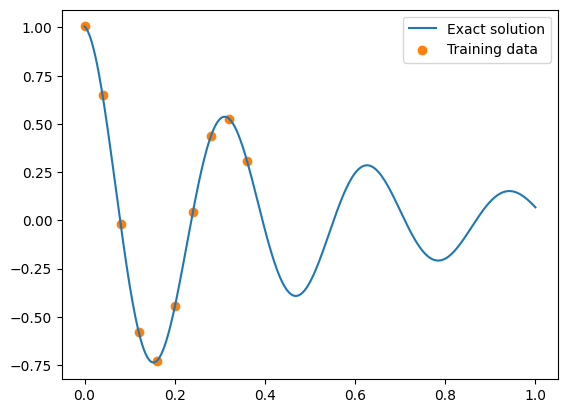

In [4]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [5]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [6]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [7]:
class FCN(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
            ])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
                ]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [8]:
import os

files_dir = 'plots'
if not os.path.exists(files_dir):
    os.makedirs(files_dir)

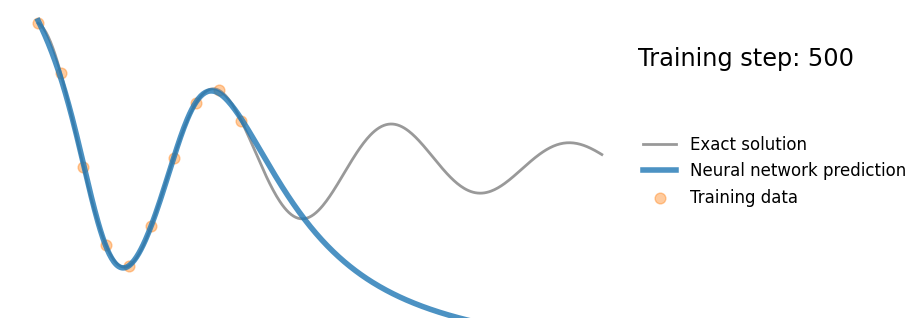

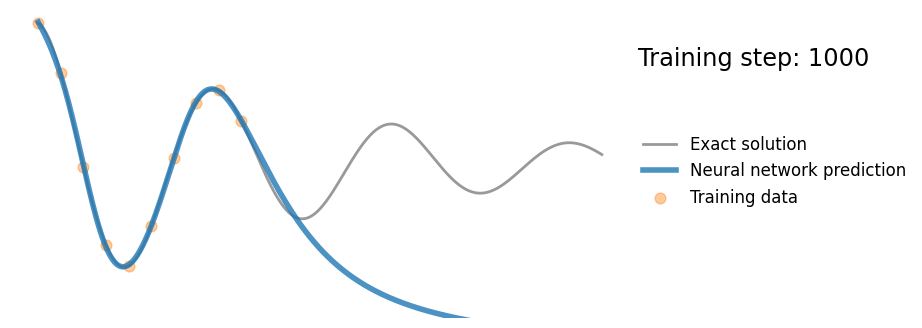

In [9]:
torch.manual_seed(123)

model = FCN(1,1,32,3)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

files = []
for i in range(1000):

    optimizer.zero_grad()

    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)
    loss.backward()

    optimizer.step()

    if (i+1) % 10 == 0:
        yh = model(x).detach()
        plot_result(x,y,x_data,y_data,yh)
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("nn.gif", files, fps=20, loop=0)

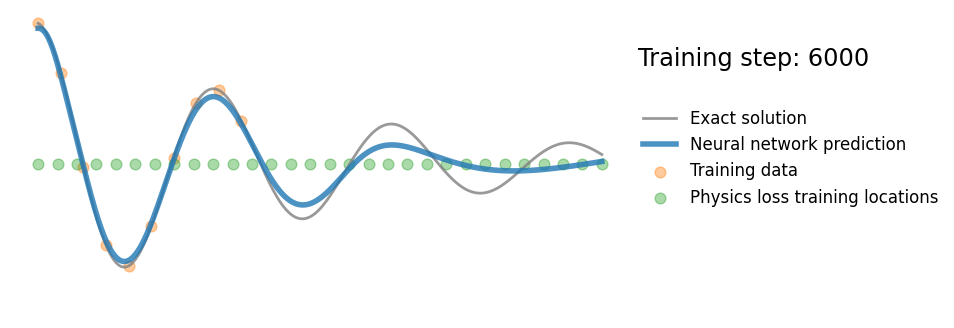

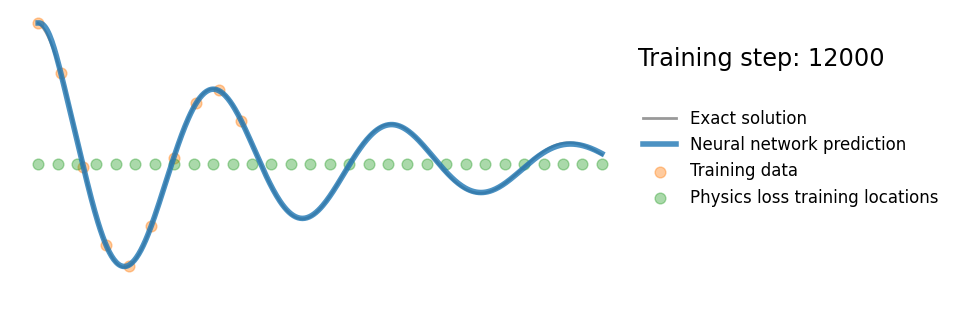

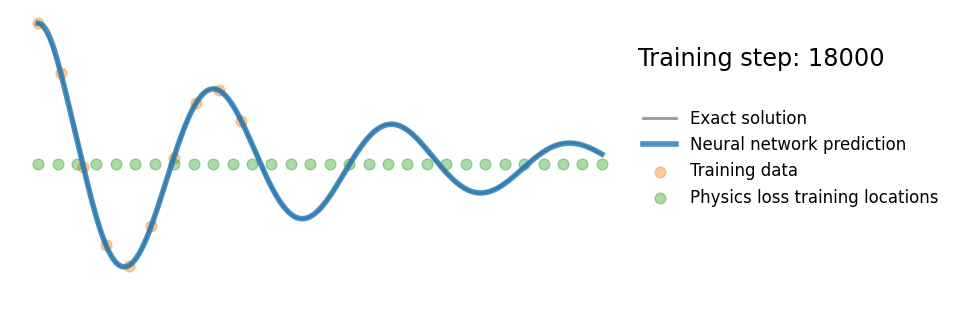

In [10]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

mu, k = 2*d, w0**2 # m = 1

torch.manual_seed(123)

model = FCN(1,1,32,3)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

files = []
for i in range(20000):

    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)

    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0] # computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0] # computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2
    loss.backward()

    optimizer.step()

    # plot the result as training progresses
    if (i+1) % 150 == 0:
        yh = model(x).detach()
        xp = x_physics.detach()
        plot_result(x,y,x_data,y_data,yh,xp)
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("pinn.gif", files, fps=20, loop=0)